In [1]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [4]:
# Optimize
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Data Augmentation block
from tensorflow.keras import layers, callbacks
data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
    layers.RandomZoom(0.1),
])

In [7]:
def build_mobilenetv2_model(trainable_layers=0):
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False if trainable_layers == 0 else True

    if trainable_layers > 0:
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

def compile_model(model, lr=1e-3):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )


In [8]:
model = build_mobilenetv2_model(trainable_layers=0)
compile_model(model)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

print("🔧 Training Phase 1 (Frozen base)...")
history_1 = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stop])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔧 Training Phase 1 (Frozen base)...
Epoch 1/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 1065s 5s/step - accuracy: 0.8395 - auc: 0.9095 - loss: 0.3688 - val_accuracy: 0.9462 - val_auc: 0.9882 - val_loss: 0.1571
Epoch 2/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.9232 - auc: 0.9754 - loss: 0.1971 - val_accuracy: 0.9531 - val_auc: 0.9905 - val_loss: 0.1238
Epoch 3/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.9408 - auc: 0.9834 - loss: 0.1614 - val_accuracy: 0.9565 - val_auc: 0.9918 - val_loss: 0.1142
Epoch 4/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.9387 - auc: 0.9840 - loss: 0.1584 - val_accuracy: 0.9497 - val_auc: 0.9909 - val_loss: 0.1168
Epoch 5/5
214/214 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.9415 - auc: 0.9852 - loss: 0.1526 - val_accuracy: 0.9522 - val_auc: 0.9909 - val_loss: 0.1180


In [9]:
print(" Fine-tuning Phase 2 (Unfreezing)...")
model = build_mobilenetv2_model(trainable_layers=30)
compile_model(model, lr=1e-5)

history_2 = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stop, lr_reduce])


 Fine-tuning Phase 2 (Unfreezing)...
Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.7142 - auc: 0.7794 - loss: 0.5962 - val_accuracy: 0.8874 - val_auc: 0.9592 - val_loss: 0.2840 - learning_rate: 1.0000e-05
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.9140 - auc: 0.9693 - loss: 0.2243 - val_accuracy: 0.9138 - val_auc: 0.9791 - val_loss: 0.2006 - learning_rate: 1.0000e-05
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.9381 - auc: 0.9828 - loss: 0.1649 - val_accuracy: 0.9326 - val_auc: 0.9861 - val_loss: 0.1607 - learning_rate: 1.0000e-05
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.9449 - auc: 0.9856 - loss: 0.1490 - val_accuracy: 0.9428 - val_auc: 0.9894 - val_loss: 0.1401 - learning_rate: 1.0000e-05
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.9583 - auc: 0.9888 - loss: 0.1259 - val_accuracy: 0.9522 - val_auc: 0.9912 - val_loss: 0.1298 - learning_rate: 1.0000e-05
Epoch 6/10
214/214

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_probs =model.predict(test_ds)
y_pred = (y_probs > 0.5).astype("int").flatten()


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


In [11]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


Accuracy: 95.22%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.95      0.95       293
   PNEUMONIA       0.95      0.96      0.95       293

    accuracy                           0.95       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.95      0.95      0.95       586



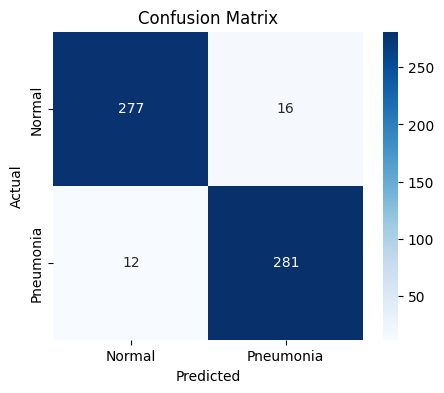

In [12]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")


AUC Score: 0.9925


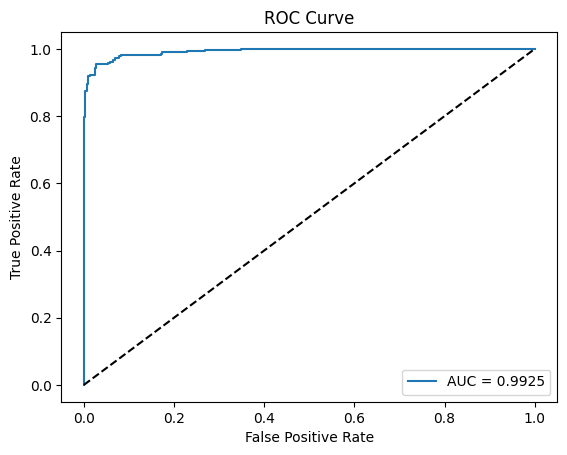

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [15]:
model.save("mobilenetv2.keras")
from google.colab import files
files.download("mobilenetv2.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>